# Some integration tests for cepstral-norm calculation

In [1]:
%matplotlib inline
import time
import timeit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from types import SimpleNamespace
from typing import Sequence, Callable
from tqdm.notebook import tqdm

from bioslds.cepstral import OnlineCepstralNorm
from bioslds.arma import Arma
from bioslds.arma_hsmm import sample_switching_models
from bioslds.sources import GaussianNoise
from bioslds.utils import rle_decode
from bioslds.plotting import FigureManager, colorbar, show_latent

## Useful definitions

In [2]:
def get_exact_cepstral_norm(arma: Arma) -> float:
    """ Calculate cepstral norm of ARMA process.
    
    This is an exact calculation using the ARMA coefficients. See, e.g., De Cock and
    De Moor (2002). Subspace angles between ARMA models. Systems and Control Letters,
    46(4), 265–270.
    
    Parameters
    ----------
    arma
        The ARMA process whose cepstral norm needs to be calculated.
        
    
    Returns the cepstral norm of the ARMA process.
    """
    poles = arma.calculate_poles()
    zeros = arma.calculate_zeros()

    # using the formula from the paper
    mix_term = 2 * np.sum(np.log(np.abs(1 - np.outer(poles, zeros.conj()))))
    pole_term = np.sum(np.log(np.abs(1 - np.outer(poles, poles.conj()))))
    zero_term = np.sum(np.log(np.abs(1 - np.outer(zeros, zeros.conj()))))

    return mix_term - pole_term - zero_term

## Test that cepstral-norm estimates match expectations

In [3]:
rng = np.random.default_rng(412)

# sigmas chosen so the outputs of both processes have aproximately unit variance
accuracy_test = SimpleNamespace(
    arma1=Arma([-0.474], [], default_source=GaussianNoise(rng=1, scale=0.88)),
    arma2=Arma([0.2], [], default_source=GaussianNoise(rng=2, scale=0.98)),
    arma3=Arma([0.667], [], default_source=GaussianNoise(rng=3, scale=0.75)),
    order=3,
    rate=1 / 300,
)
accuracy_test.armas = [accuracy_test.arma1, accuracy_test.arma2, accuracy_test.arma3]

samples1 = accuracy_test.arma1.transform(100000)
samples2 = accuracy_test.arma2.transform(100000)
samples3 = accuracy_test.arma3.transform(100000)

print(
    "these should be close to 1:", np.std(samples1), np.std(samples2), np.std(samples3)
)

accuracy_test.timeline = [(0, 800), (1, 1200), (0, 1000), (2, 500), (1, 700), (2, 1000)]
accuracy_test.usage_seq = rle_decode(accuracy_test.timeline)

accuracy_test.sig = sample_switching_models(
    accuracy_test.armas, accuracy_test.usage_seq, X=GaussianNoise(3)
)

accuracy_test.exact_norms = np.asarray(
    [get_exact_cepstral_norm(_) for _ in accuracy_test.armas]
)
accuracy_test.exact_norm_seq = accuracy_test.exact_norms[accuracy_test.usage_seq]

accuracy_test.cepstral_estimator = OnlineCepstralNorm(
    1, accuracy_test.order, rate=accuracy_test.rate
)
accuracy_test.approx_norm_seq = accuracy_test.cepstral_estimator.transform(
    accuracy_test.sig[:, None]
)

these should be close to 1: 0.9964560362532199 0.9995296208883906 1.0046125847510405


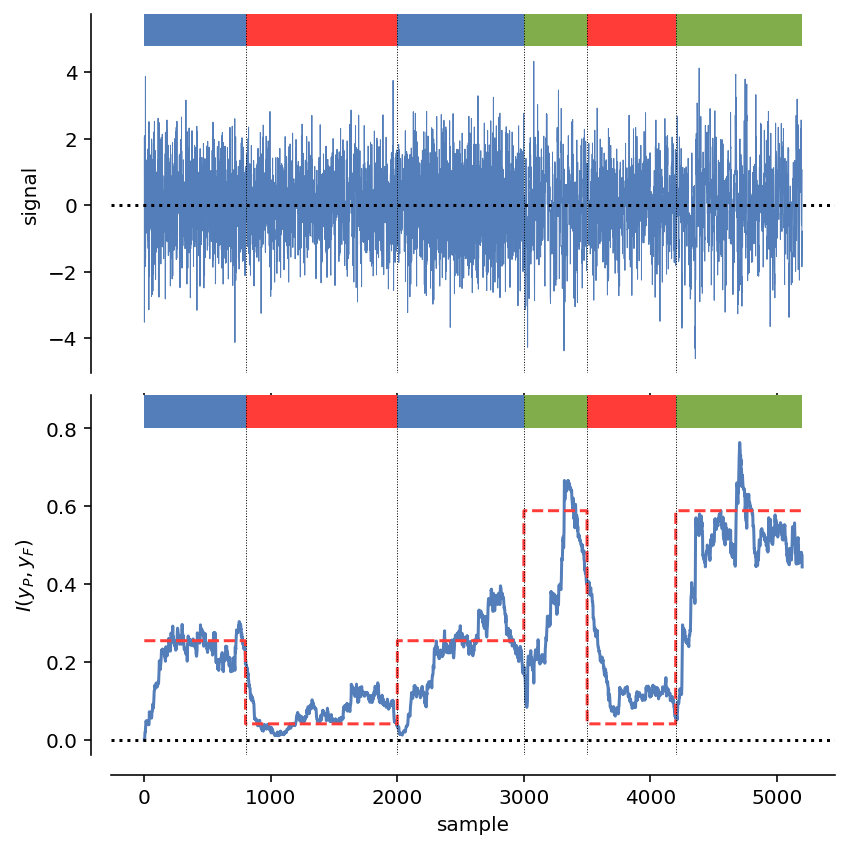

In [4]:
with FigureManager(2, 1, sharex=True, figsize=(6, 6)) as (_, (ax1, ax2)):
    ax1.plot(accuracy_test.sig, lw=0.5)
    ax1.set_ylabel("signal")
    ax1.axhline(0, c="k", ls=":")

    show_latent(accuracy_test.usage_seq, ax=ax1)

    ax2.plot(accuracy_test.approx_norm_seq)
    ax2.plot(accuracy_test.exact_norm_seq, ls="--", c="C1", label="exact")
    ax2.set_xlabel("sample")
    ax2.set_ylabel("$I(y_P, y_F)$")
    
    ax2.axhline(0, c="k", ls=":")

    show_latent(accuracy_test.usage_seq, ax=ax2)

sns.despine(bottom=True, ax=ax1)

## Benchmark `OnlineCepstralNorm.transform` speed

In [5]:
def benchmark_cepstral(
    cepstral: OnlineCepstralNorm,
    sample_sizes: Sequence,
    rng: np.random.Generator,
    progress: Callable = None,
    n_rep: int = 3,
):
    """ Benchmark speed of `OnlineCepstralNorm.transform`.
    
    This runs `OnlineCepstralNorm.transform` for different sample sizes,
    benchmarking the execution speed.
    
    Parameters
    ----------
    cepstral
        Cepstral-norm calculator to benchmark.
    sample_sizes
        Sequence indicating which sample sizes to use.
    rng
        Random number generator for creating input data.
    progress
        Callable to track progress.
    n_rep
        Number of times to repeat the time measurement. The first time,
        `timeit`s `autorange` is used to determine a good number of
        iterations, then `repeat` is called with `n_rep - 1` repeats
        and `number` set to the count returned by `autorange`.
    
    Returns a tuple of arrays, `(sample_sizes, times)`, with the first
    element, `sample_sizes`, simply a clone of the input argument, and the
    second element, `times`, indicating the times (in seconds) it took to
    transform each of the data sets with sizes given by `sample_sizes`. The
    timings are obtained by potentially running the task many times, using
    the `autorange` member from `timeit.Timer`.
    """
    times = np.zeros(len(sample_sizes))
    if progress is None:
        progress = lambda it: it
    for i, n in enumerate(progress(sample_sizes)):
        crt_x = rng.normal(size=(n, cepstral.n_features))
        timer = timeit.Timer(lambda: cepstral.transform(crt_x))
        count, total_time = timer.autorange()

        other_times = timer.repeat(n_rep - 1, count)
        best_time = min(total_time, np.min(other_times))

        times[i] = best_time / count

    return sample_sizes, times

In [6]:
spd_test = SimpleNamespace(
    orders=[2, 5, 25],
    n_signals=[1, 5],
    sample_sizes=np.geomspace(10, 10000, 10).astype(int),
)

rng = np.random.default_rng(1)
spd_test.results = {}
spd_test.all_modes = OnlineCepstralNorm._available_modes
for crt_mode in tqdm(spd_test.all_modes, desc="mode"):
    for crt_order in tqdm(spd_test.orders, desc="order"):
        for crt_n_signals in tqdm(spd_test.n_signals, desc="n_signals"):
            crt_cepstral = OnlineCepstralNorm(
                n_features=crt_n_signals, order=crt_order, rate=0.01
            )
            crt_cepstral._mode = crt_mode
            crt_sizes, crt_times = benchmark_cepstral(
                crt_cepstral, spd_test.sample_sizes, rng, progress=tqdm
            )

            spd_test.results[crt_mode, crt_order, crt_n_signals] = {
                "cepstral": crt_cepstral,
                "sizes": crt_sizes,
                "times": crt_times,
            }

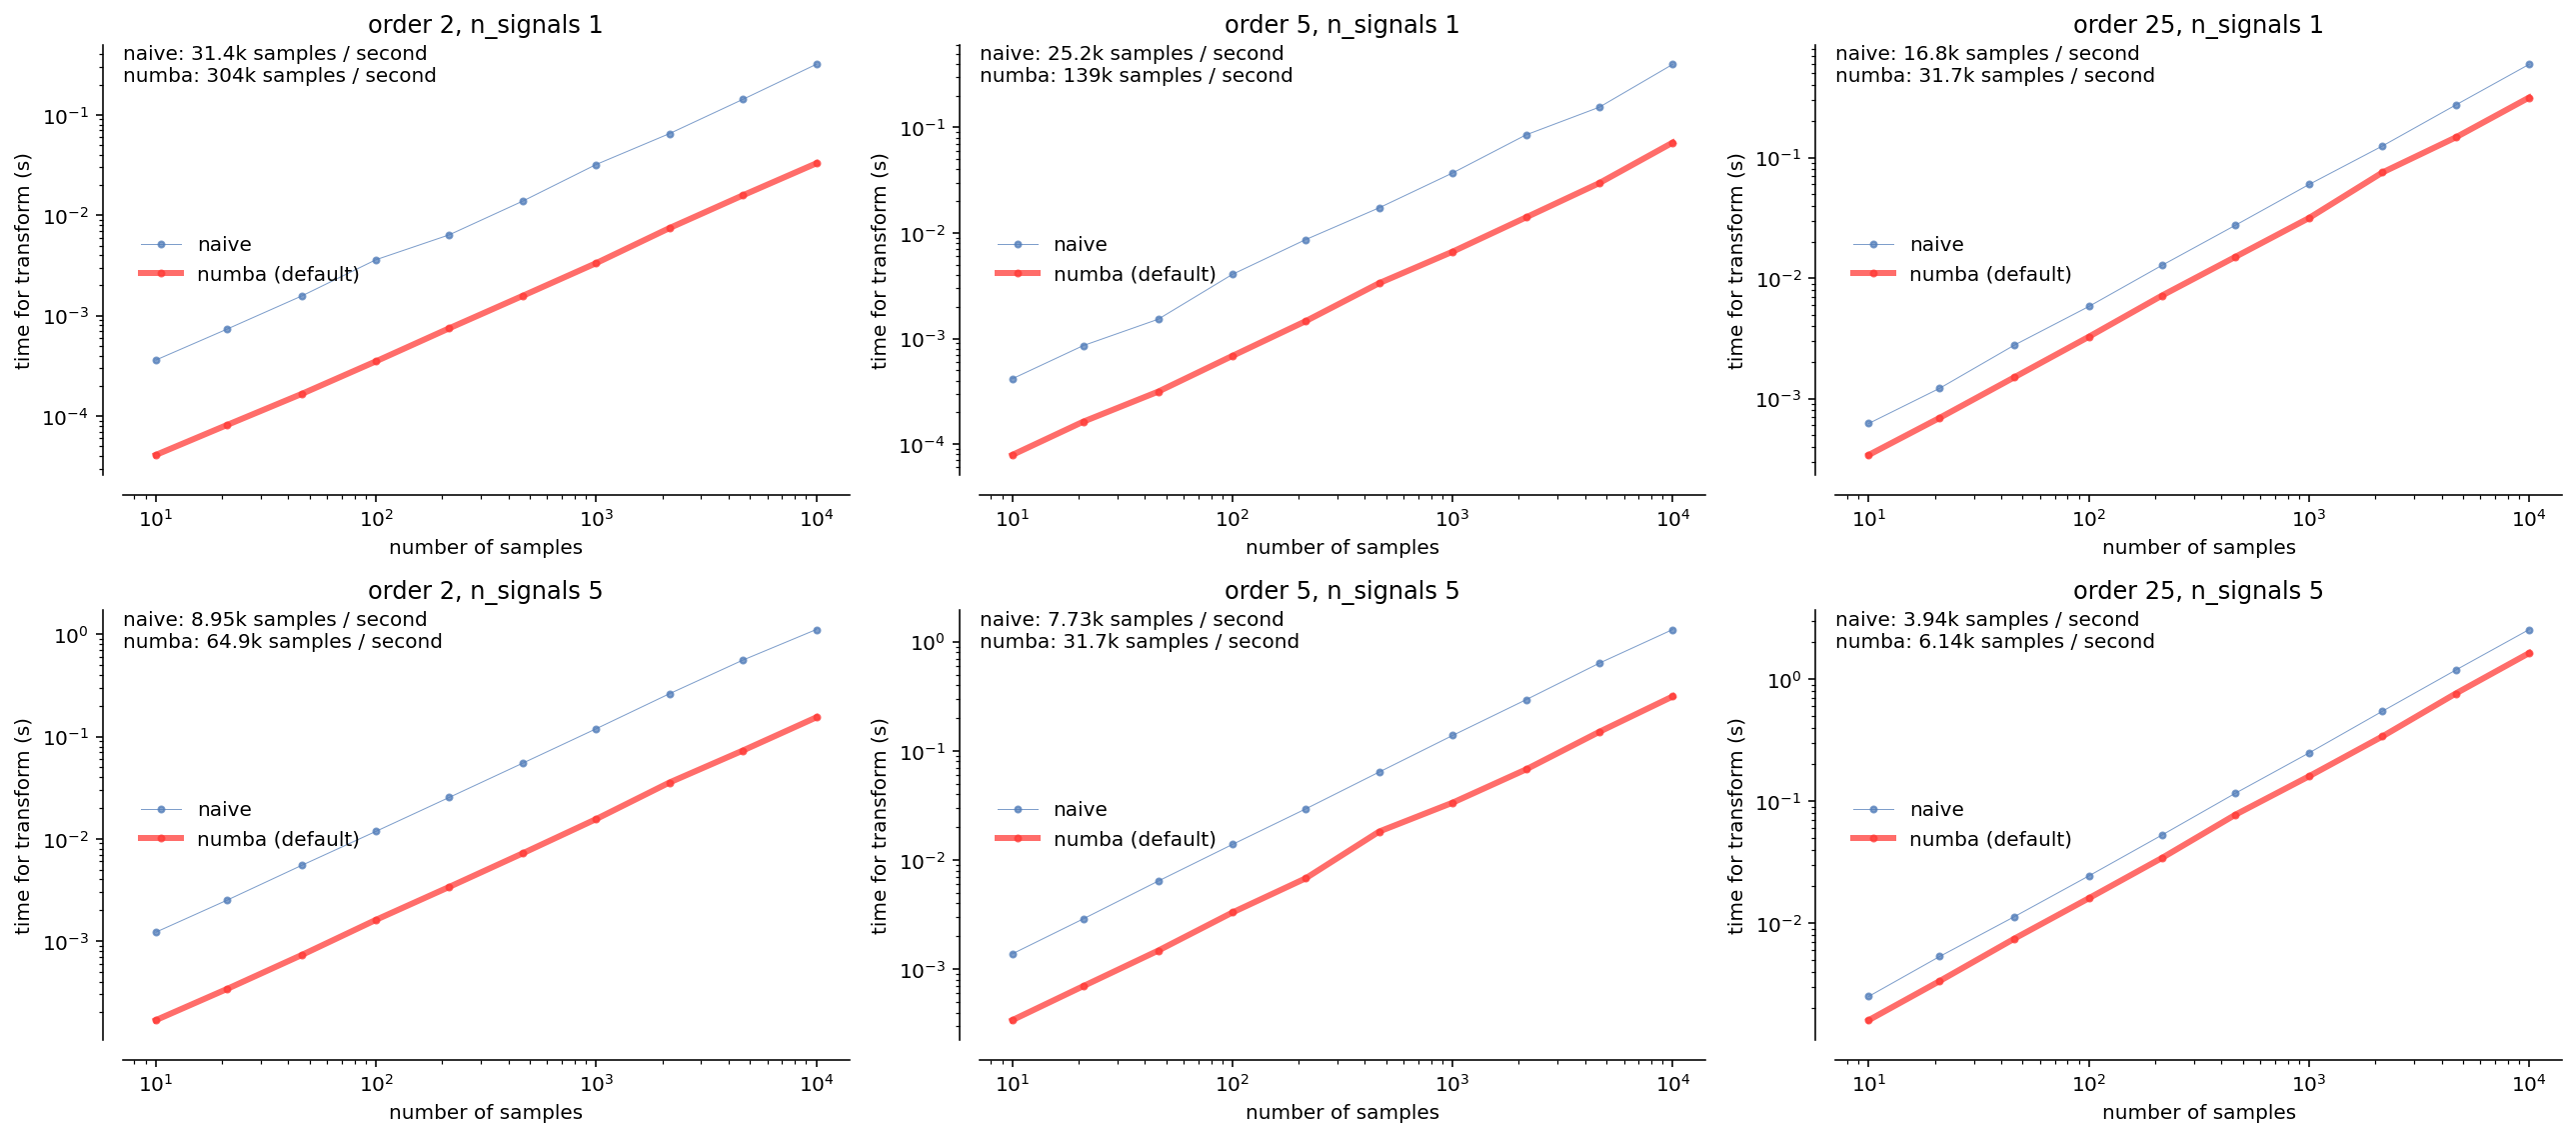

In [7]:
default_mode = OnlineCepstralNorm(2, 3)._mode

with FigureManager(len(spd_test.n_signals), len(spd_test.orders)) as (_, axs):
    for i, ax_row in enumerate(axs):
        crt_n_signals = spd_test.n_signals[i]
        for j, ax in enumerate(ax_row):
            crt_order = spd_test.orders[j]
            crt_rates = []
            crt_annot_list = []
            for crt_mode in spd_test.all_modes:
                crt_results = spd_test.results[crt_mode, crt_order, crt_n_signals]
                is_default = crt_mode == default_mode

                if not is_default:
                    crt_label = crt_mode
                else:
                    crt_label = crt_mode + " (default)"

                ax.loglog(
                    crt_results["sizes"],
                    crt_results["times"],
                    ".-",
                    label=crt_label,
                    alpha=0.75,
                    lw=3 if is_default else 0.5,
                )

                crt_rate = crt_results["sizes"][-1] / crt_results["times"][-1] / 1000
                crt_rates.append(crt_rate)
                crt_annot_list.append(f"{crt_mode}: {crt_rate:.3g}k samples / second")

            ax.set_title(f"order {crt_order}, n_signals {crt_n_signals}")
            ax.legend(frameon=False, loc="center left")

            ax.set_xlabel("number of samples")
            ax.set_ylabel("time for transform (s)")

            crt_annot = "\n".join(crt_annot_list)
            ax.annotate(
                crt_annot, (0.0, 1.0), xycoords="axes fraction", verticalalignment="top"
            )